### a POD problem with initial values

POD tries to best parametrize a given solution trajectory.  Nonetheless, POD is generally used as a method to approximate the actual model. 

This example shows a case, in which for a random initial value, the POD model reduction fails in so far as the reduction leads to an unacceptable approximation error. In fact, for any grade of the POD reduction, the relative error is about $1$, which means that the computed approximation is as good as just taking the zero function.

Furthermore

 * the *singular values* of the snapshot matrix nicely and quickly decay to machine precision `1e-16`, which is commonly used as an indicator for POD giving a suitable reduction
 * this potential problem might be less obvious but inherent in more general systems


In [23]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
epsi = 1./100
tE = 2
Nts = 100                        # number of time points and snapshots
N = 10                           # dimension of the model will be 2*N
tmesh = np.linspace(0, tE, Nts)  # the time grid
discmodeslist = np.arange(2*N)   # number of modes to be discarded
inival = np.cos(np.linspace(0, 2*np.pi, 2*N))

# ## The initial values for the tests
tstinivalsin = np.sin(np.linspace(0, 2*np.pi, 2*N))
tstinivalrnd = np.random.randn(2*N)
tstinivdict = {'same initial value': inival,
               'other initial value': tstinivalsin,
               'random initial value': tstinivalrnd}
inivallist = tstinivdict.keys()

In [24]:
scalevec = np.arange(N)
scaledeye = np.diag(scalevec)
# a simple Identity would do but this scaling gives a smoother decay of the singular values
nzero = np.zeros((N, N))
A = np.vstack([np.hstack([nzero, 1./epsi*scaledeye]),
               np.hstack([nzero, -epsi*scaledeye])])
def rhs(vvec, t):
    return A.dot(vvec).flatten()

In [25]:
soltrajec = odeint(rhs, inival, tmesh)
V, dg, _ = np.linalg.svd(soltrajec.T)
nrmfulsol = np.linalg.norm(soltrajec)

### ### The Singular Values show a nice decay

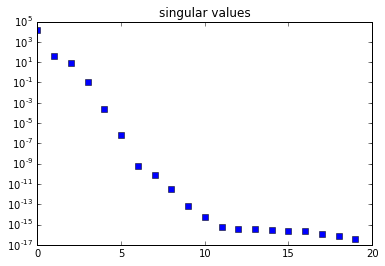

In [26]:
plt.figure(333)
plt.semilogy(dg, 's')
plt.title('singular values')

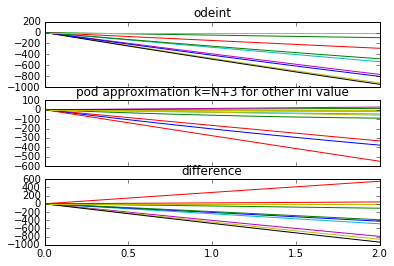

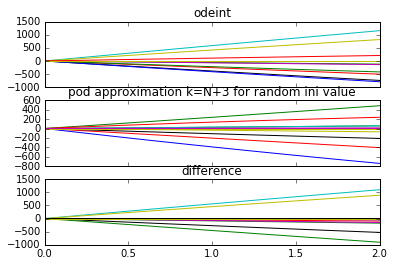

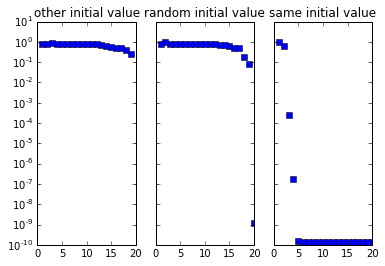

In [27]:
fig, axarr = plt.subplots(1, 3, sharey=True, num=11)
for kiniv, whichiniv in enumerate(inivallist):
    tstiniv = tstinivdict[whichiniv]
    errlist = []
    for discmodes in discmodeslist:
        k = 2*N - discmodes
        vone = V[:, :k]
        redini = vone.T.dot(tstiniv)

        reda = vone.T.dot(A.dot(vone))
        
        def redrhs(vvec, t):
            return reda.dot(vvec).flatten()

        redsoltrajec = odeint(redrhs, redini, tmesh)

        infrdsol = vone.dot(redsoltrajec.T)
        tsttrajec = odeint(rhs, tstiniv, tmesh)

        diffsol = infrdsol - tsttrajec.T

        nrmdifsol = np.linalg.norm(diffsol)
        relnrmdifsol = nrmdifsol/nrmfulsol
        errlist.append(relnrmdifsol)
        if k == N+3 and whichiniv == 'random initial value':
            figt, axtarr = plt.subplots(3, sharex=True, num=2)
            axtarr[0].plot(tmesh, tsttrajec)
            axtarr[0].set_title('odeint')
            axtarr[1].plot(tmesh, infrdsol.T)
            axtarr[1].set_title('pod approximation k=N+3 for random ini value')
            axtarr[2].plot(tmesh, -diffsol.T)
            axtarr[2].set_title('difference')

        if k == N+3 and whichiniv == 'other initial value':
            figt, axtarr = plt.subplots(3, sharex=True, num=3)
            axtarr[0].plot(tmesh, tsttrajec)
            axtarr[0].set_title('odeint')
            axtarr[1].plot(tmesh, infrdsol.T)
            axtarr[1].set_title('pod approximation k=N+3 for other ini value')
            axtarr[2].plot(tmesh, -diffsol.T)
            axtarr[2].set_title('difference')

    axarr[kiniv].semilogy(2*N-np.array(discmodeslist), np.array(errlist), 's')
    axarr[kiniv].set_title(whichiniv)

plt.show()

### ### The approximation is bad -- for other initial values

Note, for the *other* and the *random* initial value, that the relative error is about $1$ and shows almost no decay if more POD modes are included.

Only if the full basis is used, i.e. no reduction is performed, a useful estimation of the solution is obtained.

For the same initial value, the POD reduction is very nice.

### ### what goes wrong here?

For illustration, consider the ODE

$$
 \begin{bmatrix} I & 0 \\ 0 & I \end{bmatrix} 
 \begin{bmatrix} \dot x_1 \\  \dot x_2 \end{bmatrix} 
	 =
	 \begin{bmatrix} 0 & \frac{1}{\varepsilon}I \\ 0 & -\varepsilon I \end{bmatrix} 
 \begin{bmatrix} x_1 \\  x_2 \end{bmatrix} ,
     \quad 
     \begin{bmatrix} x_1(0) \\  x_2(0) \end{bmatrix}
     = 
     \begin{bmatrix} x_1^0 \\  x_2^0 \end{bmatrix}
$$
with an $\varepsilon > 0$. (In the presented example, the $I$s in $A$ are replaced by diagonal matrix with different entries on the diagonal). 

For any initial value $x_0=[\alpha^T, \beta^T]^T$, the space in which the solution evolves is given as
$$
  \textsf{span}
  \left\{ 
  x_0, Ax_0, A^2x_0, ...
  \right\}
  =
 \textsf{span}
 \left\{ 
  \begin{bmatrix}\alpha \\ \beta\end{bmatrix},
  \begin{bmatrix}\varepsilon^{-1}\beta \\ \varepsilon\beta\end{bmatrix},
  \begin{bmatrix}\beta \\ \varepsilon^2\beta\end{bmatrix},
    \begin{bmatrix}\varepsilon\beta \\ \varepsilon^3\beta\end{bmatrix},
  ...
  \right\} 
  =
   \textsf{span}
 \left\{ 
  \begin{bmatrix}\alpha \\ \beta\end{bmatrix},
  \begin{bmatrix}\varepsilon^{-1}\beta \\ \varepsilon\beta\end{bmatrix}
  \right\}.
$$

Here, the data space is (atmost) two-dimensional. In the presented example it is (atmost) $N$-dimensional. 

Since the snapshots and the POD modes only capture the trajectory, they only contain the space that is generated by the particular initial condition. Consequently, all components of a (initial) state, that are in the complement of this space of evolution, are set to zero by the POD projection. 

Of course, this is what model reduction does -- setting certain components to zero. However, these components should be defined mainly by the model and not, like in the presented case, by the initial value.